# CS 251/340 Machine Learning Final Project

# Authors: Aram Abrahamyan & Areg Vardanyan

# Instructor: Davit Ghazaryan

# Topic: Music Genre Recognition

---

### Importing the necessary libraries

In [34]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings('ignore')

### Reading the data

The GTZAN dataset provides 2 csv files. One contains features extracted from first 30 seconds of a WAV file; however, contains just 1000 data points. The other one contains features extracted from first 3 seconds of the same WAV files and contains 9990 data points. Firstly, we have tried to use the small dataset, thinking that in the tradeoff between more information/less data and less information/more data the first variant would be more preferrable, but it was not the case, so we moved forward with the larger dataset.

In [4]:
df = pd.read_csv('GTZAN/Data/features_3_sec.csv')

There are 10 unique classes in the dataset

In [5]:
f'Number of unique classes: {len(df.label.unique())}'

'Number of unique classes: 10'

And they are equally distributed, so there is no class imbalance.

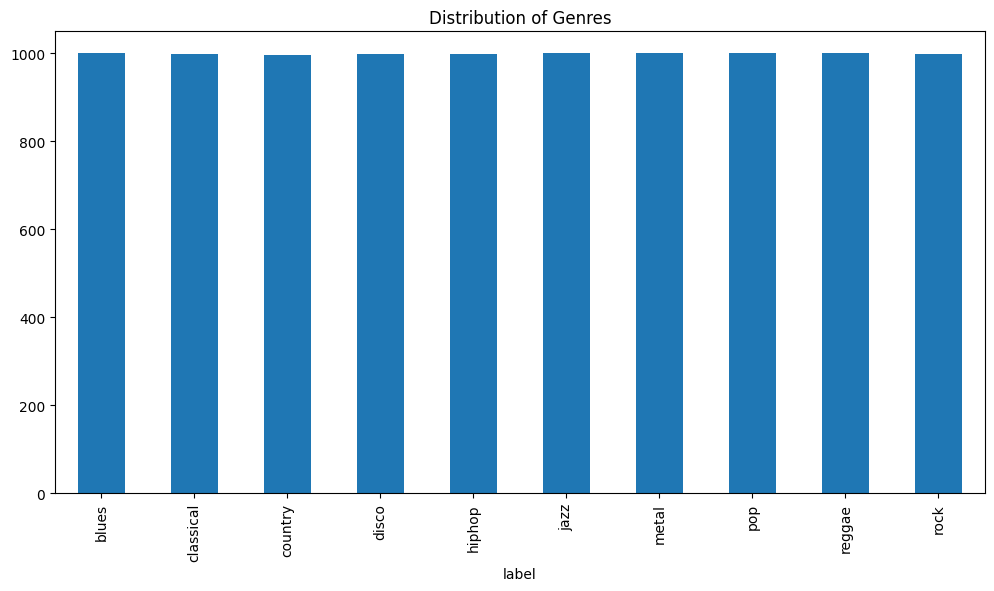

In [8]:
df['label'].groupby(df['label']).count().plot(kind='bar', figsize=(12, 6), title='Distribution of Genres');

### Defining a function to further assess the implemented algorithms

As the default function for getting all metrics for given model from sci-kit learn was a bit confusing for us, we have decided to define a function ourselves that will get the metrics(accuracy, precision, recall, f1) as well as the confusion matrix and return them.

In [9]:
def get_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['label'].unique())
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nConfusion Matrix:')

### Separating the features and labelest from the DataFrame

Further we separate the labels from the DataFrame and do the train/test split.

In [10]:
X = df.iloc[:, 2:-1].values  # Features
y = df["label"].values  # Genre labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Normalizing (Z-score normalization) the features

For the next step we use the StandardScaler function from sci-kit learn to scale the features.

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Afterwards, we decided to run our first classifier, which is RandomForest, and look at the initial result.

---

## Random Forest

In [12]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

Metrics for Random Forest:
Accuracy: 0.8578578578578578
Precision: 0.8587524244563987
Recall: 0.8578578578578578
F1: 0.8568367757024803
Confusion Matrix:


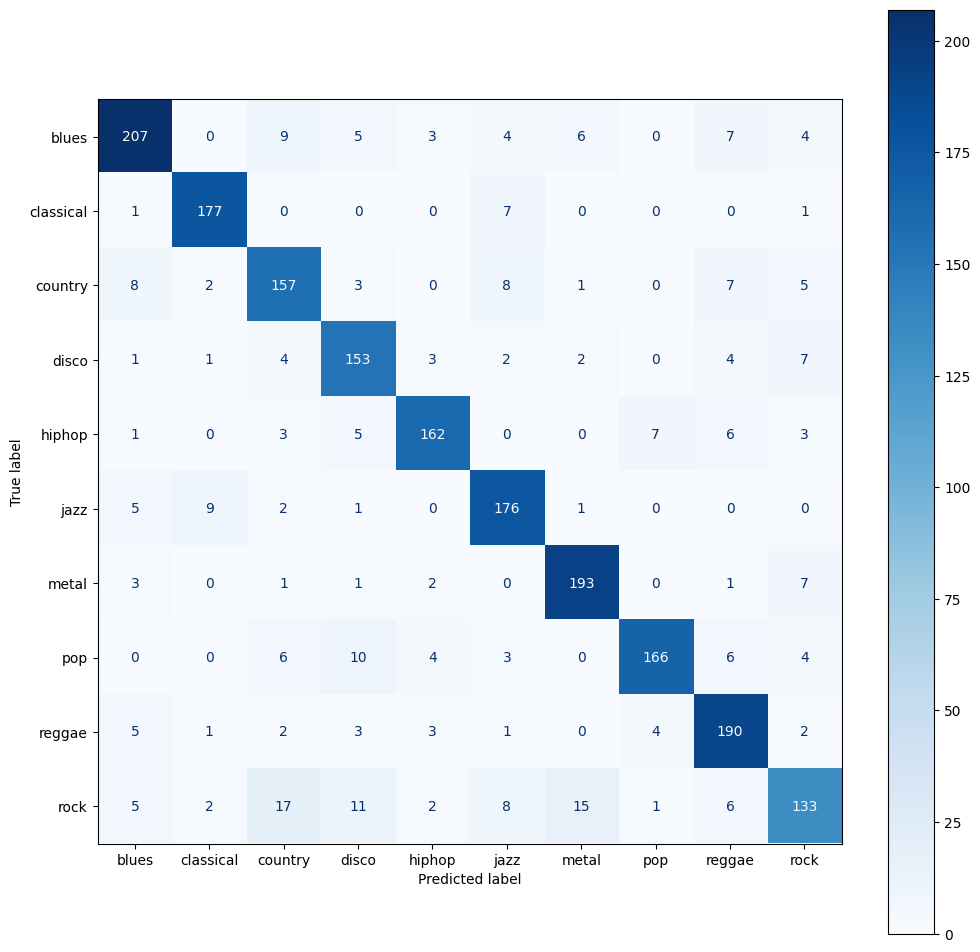

In [13]:
rf_pred = rf.predict(X_test_scaled)
print(f'Metrics for Random Forest:\n{get_metrics(y_test, rf_pred)}')

The result is pretty good; however, we can further improve it using GridSearchCV to get the best parameters according to F1 score for Random Forest using cross validation techniques.

In [15]:
gs_rf = GridSearchCV(estimator=rf, param_grid={
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}, scoring='f1_macro', cv=3, n_jobs=-1)
gs_rf.fit(X_train, y_train)
gs_rf.best_params_

{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}

Let's run Random Forest with the given parameters, and see what happens

In [17]:
rf_bp = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=100)
rf_bp.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=20)

Metrics for Random Forest:
Accuracy: 0.8633633633633634
Precision: 0.8635046920675975
Recall: 0.8633633633633634
F1: 0.8622322917520018
Confusion Matrix:


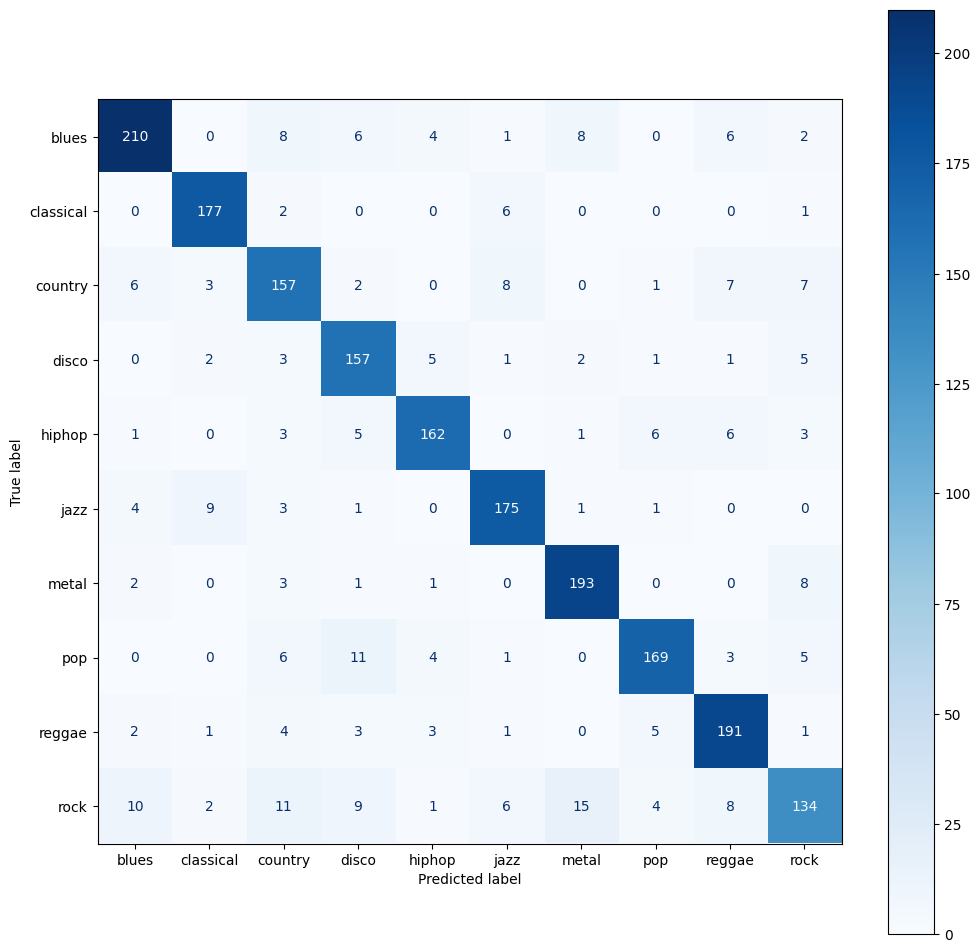

In [18]:
rf_bp_pred = rf_bp.predict(X_test_scaled)
print(f'Metrics for Random Forest:\n{get_metrics(y_test, rf_bp_pred)}')

The result got slightly better, but we can have a look at feature importance and further enhance our model.

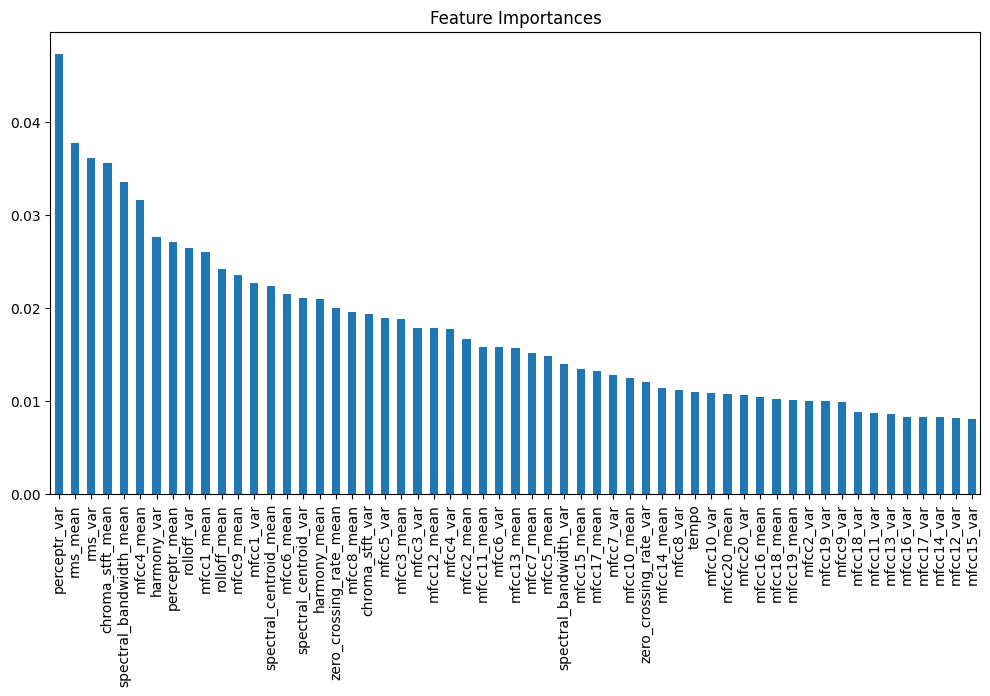

In [19]:
feature_importances = pd.Series(rf_bp.feature_importances_, index=df.columns[2:-1])
feature_importances.sort_values(ascending=False, inplace=True)
feature_importances.plot(kind='bar', figsize=(12, 6), title='Feature Importances');

Let's drop all the features under 0.01 and run the model again.

Metrics for Random Forest:
Accuracy: 0.8663663663663663
Precision: 0.8686519264744794
Recall: 0.8663663663663663
F1: 0.8653589162381559
Confusion Matrix:


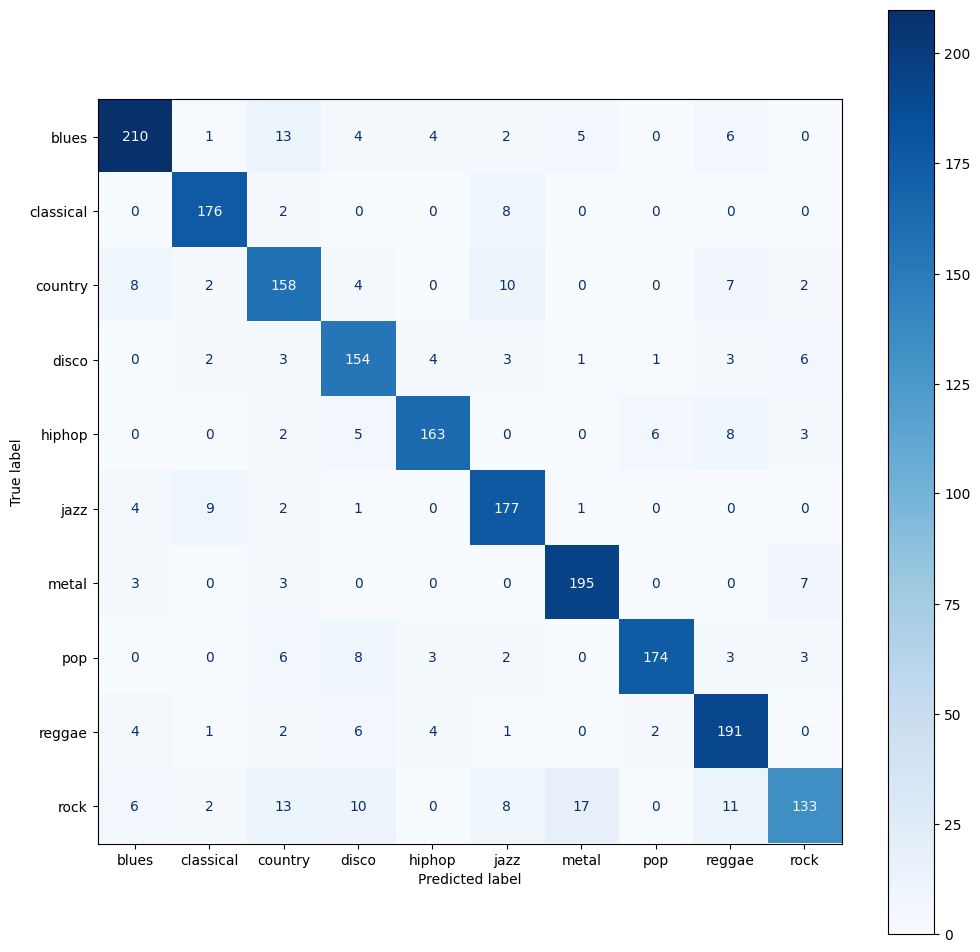

In [20]:
selector = SelectFromModel(rf_bp, threshold=0.01, prefit=True)
X_train_sr = selector.transform(X_train_scaled)
X_test_sr = selector.transform(X_test_scaled)
rf_reduced = RandomForestClassifier()
rf_reduced.fit(X_train_sr, y_train)
rf_reduced_pred = rf_reduced.predict(X_test_sr)
print(f'Metrics for Random Forest:\n{get_metrics(y_test, rf_reduced_pred)}')

The result got slightly better, so we have decided to keep going with the reduced features. X_train_sr stands for X_train scaled and reduced, the same works for X_test_sr

---

## kNN

In the same manner first we will look at the results of kNN with default parameters then run a GridSearchCV to get the best parameters.

Metrics for kNN:
Accuracy: 0.8903903903903904
Precision: 0.8938180376482062
Recall: 0.8903903903903904
F1: 0.8905205925271612
Confusion Matrix:


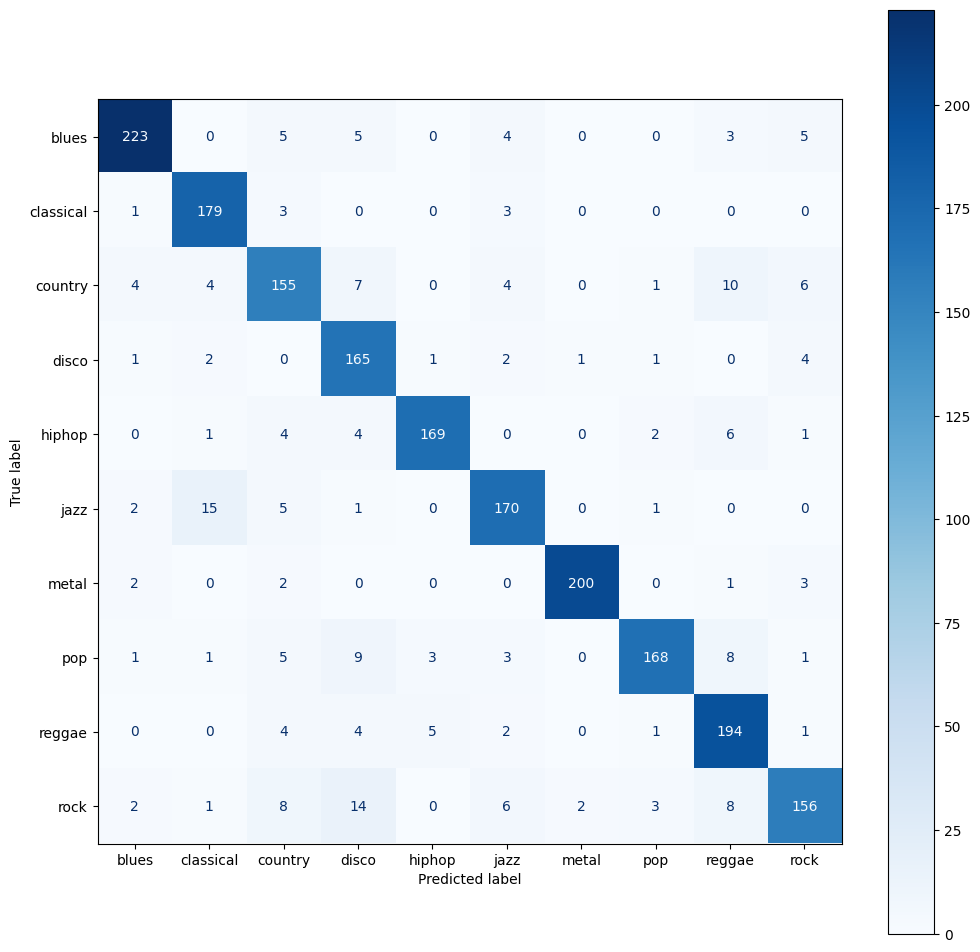

In [21]:
knn = KNeighborsClassifier()
knn.fit(X_train_sr, y_train)
knn_pred = knn.predict(X_test_sr)
print(f'Metrics for kNN:\n{get_metrics(y_test, knn_pred)}')

The results are pretty good, but using cross validation will make it even better.

## Cross Validation for kNN

In [22]:
gs_knn = GridSearchCV(estimator=knn, param_grid={
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['distance'],
    'p': [1, 2]
}, scoring='f1_macro', cv=3, n_jobs=-1)
gs_knn.fit(X_train_sr, y_train)
gs_knn.best_params_

{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

## kNN with the best parameters

Metrics for kNN:
Accuracy: 0.8903903903903904
Precision: 0.8938180376482062
Recall: 0.8903903903903904
F1: 0.8905205925271612
Confusion Matrix:


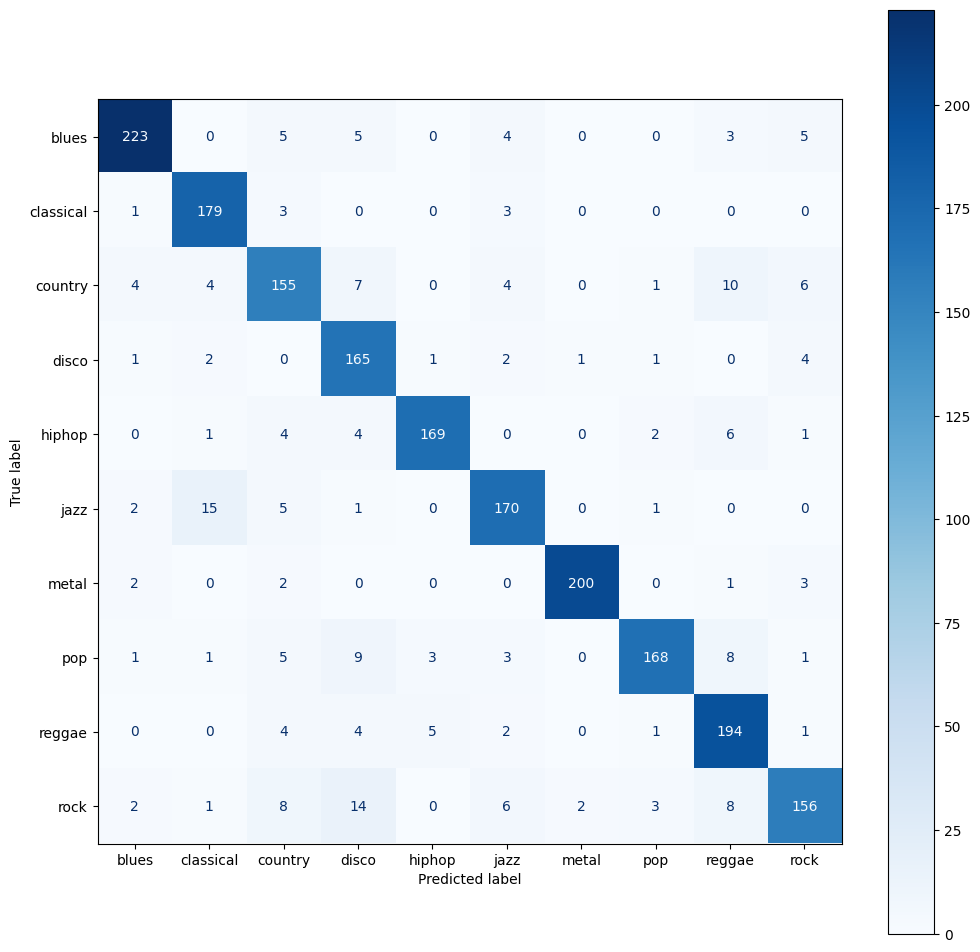

In [23]:
knn_bp = KNeighborsClassifier(n_neighbors=3, weights='distance', p=1)
knn_bp.fit(X_train_sr, y_train)
knn_bp_pred = knn.predict(X_test_sr)
print(f'Metrics for kNN:\n{get_metrics(y_test, knn_bp_pred)}')

Pretty good result for this kind of model but for sure, other models will be able to give better result.

---

## Gaussian Naive Bayes

Metrics for Gaussian Naive Bayes:
Accuracy: 0.5055055055055055
Precision: 0.5199835604195056
Recall: 0.5055055055055055
F1: 0.4811841796873621
Confusion Matrix:


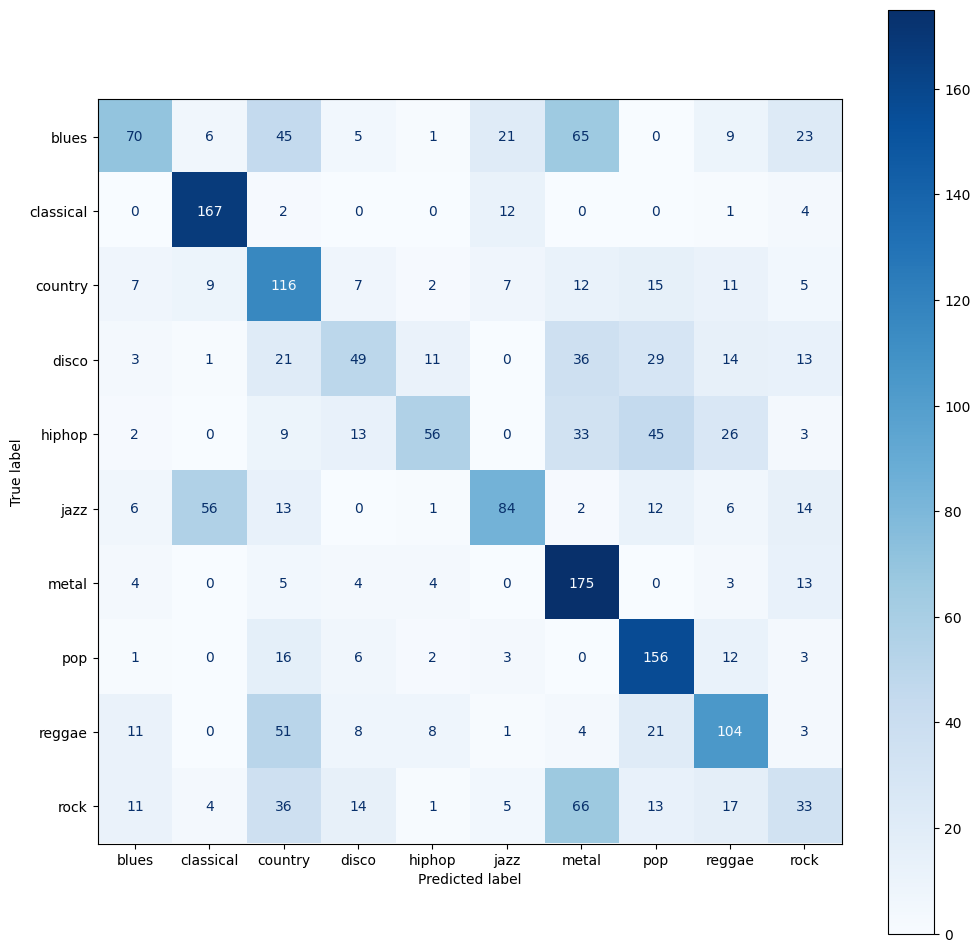

In [24]:
gnb = GaussianNB()
gnb.fit(X_train_sr, y_train)
gnb_pred = gnb.predict(X_test_sr)
print(f'Metrics for Gaussian Naive Bayes:\n{get_metrics(y_test, gnb_pred)}')

The results for Gaussian Naive Bayes are not very impressive; however, it was expected to perform like this, as the assumption behind Naive Bayes is that the features are conditionally independent, but in our case they are not. There are no parameters that can be tuned using cross validation, so we will move forward to the next model.

---

## Logistics Regression

Metrics for Logistic Regression:
Accuracy: 0.7177177177177178
Precision: 0.7149672018979077
Recall: 0.7177177177177178
F1: 0.714386692305408
Confusion Matrix:


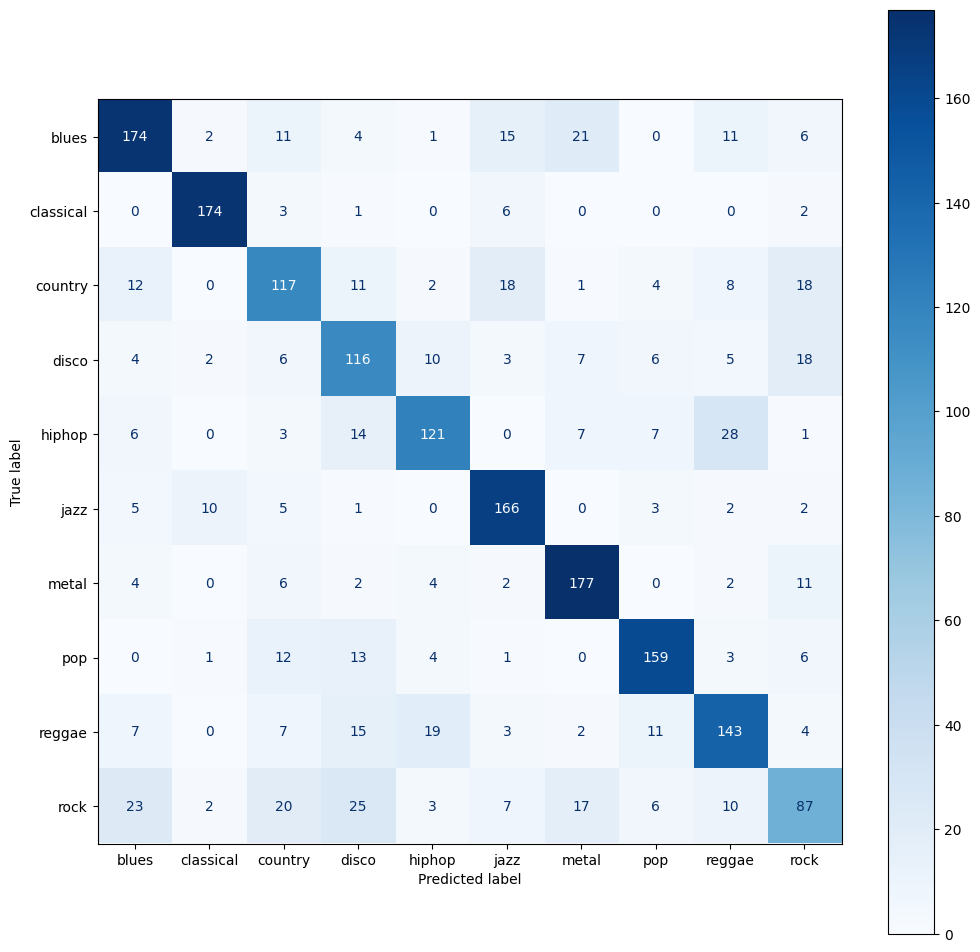

In [25]:
lr = LogisticRegression()
lr.fit(X_train_sr, y_train)
lr_pred = lr.predict(X_test_sr)
print(f'Metrics for Logistic Regression:\n{get_metrics(y_test, lr_pred)}')

The results for Logistic Regression are pretty good, but we can further improve it using GridSearchCV to get the best parameters according to F1 score for Logistic Regression using cross validation techniques.

In [26]:
gs_lr = GridSearchCV(estimator=lr, param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
}, scoring='f1_macro', cv=5, n_jobs=-1)
gs_lr.fit(X_train_sr, y_train)
gs_lr.best_params_

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Metrics for Logistic Regression:
Accuracy: 0.7177177177177178
Precision: 0.7149672018979077
Recall: 0.7177177177177178
F1: 0.714386692305408
Confusion Matrix:


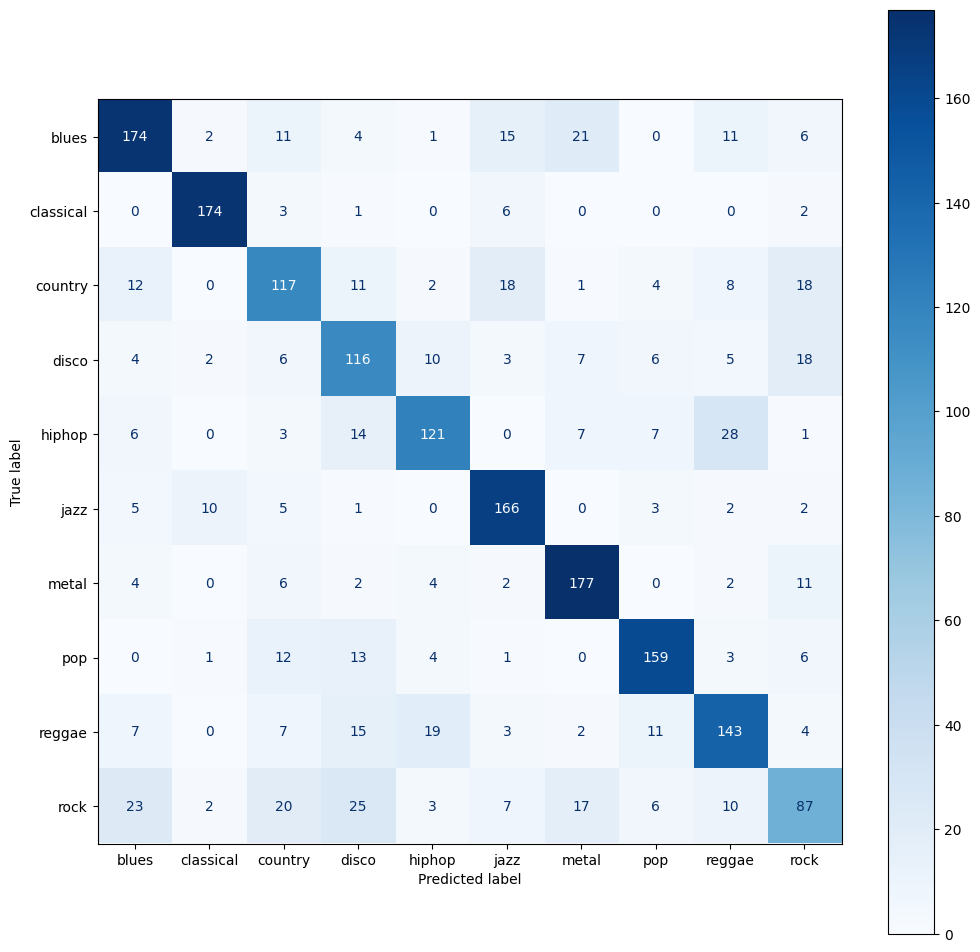

In [27]:
lr_bp = LogisticRegression(C=10, penalty='l1', solver='liblinear')
lr.fit(X_train_sr, y_train)
lr_bp_pred = lr.predict(X_test_sr)
print(f'Metrics for Logistic Regression:\n{get_metrics(y_test, lr_bp_pred)}')

The results for Logistic Regression with the best parameters are not very different from the default parameters and it was worse then our previous model which can be explained by the limitation of Logistic Regression with non-linear relationship between the data.

---

## SVM

Metrics for SVM:
Accuracy: 0.8688688688688688
Precision: 0.8722416439292218
Recall: 0.8688688688688688
F1: 0.8694459675101868
Confusion Matrix:


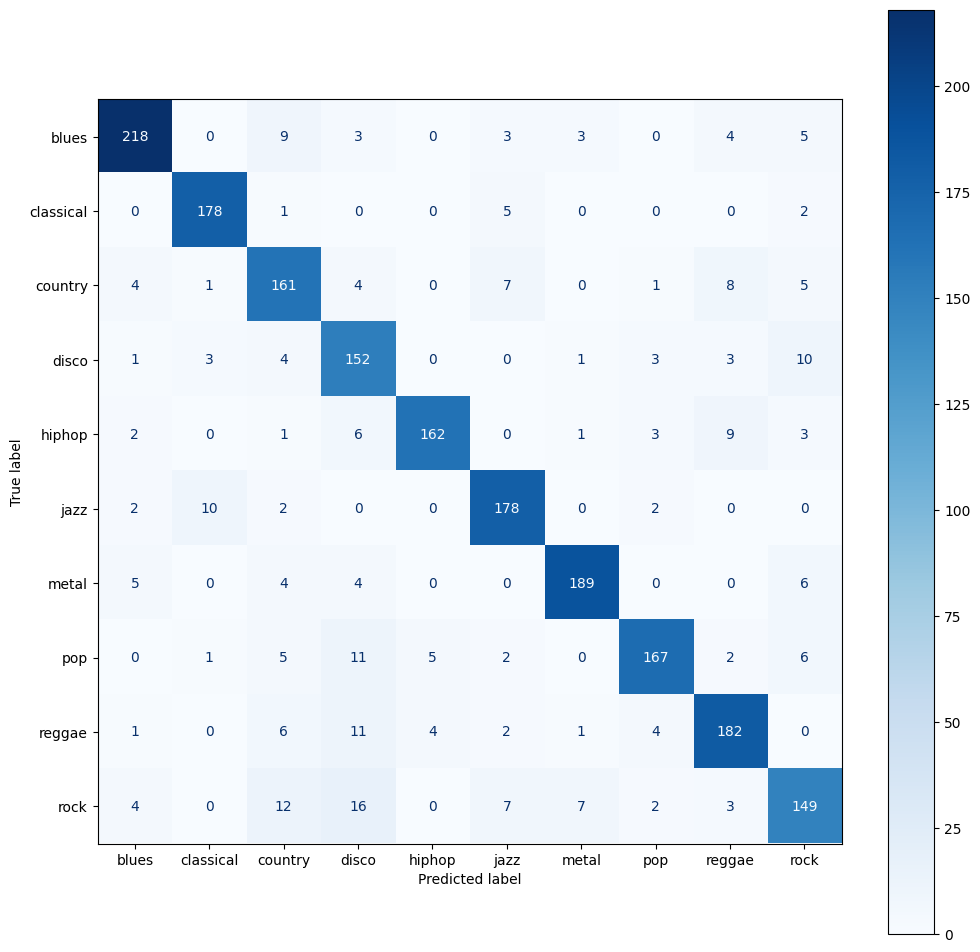

In [28]:
svm = SVC()
svm.fit(X_train_sr, y_train)
svm_pred = svm.predict(X_test_sr)
print(f'Metrics for SVM:\n{get_metrics(y_test, svm_pred)}')

Pretty good inital result, but it can be imporved using Cross Validation to decide which kernel siutes better for our data, and whihc parameters are the best

In [29]:
param_grid_linear = {
    'C': range(1, 100, 10),
    'kernel': ['linear'],
}

param_grid_rbf_sigmoid = {
    'C': range(1, 100, 10),
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

param_grid_poly = {
    'C': range(1, 100, 10),
    'kernel': ['poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
}

full_param_grid = [param_grid_linear, param_grid_rbf_sigmoid, param_grid_poly]

gs_svm = GridSearchCV(
    estimator=svm,
    param_grid=full_param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1
)
gs_svm.fit(X_train_sr, y_train)
gs_svm.best_params_

{'C': 21, 'gamma': 'scale', 'kernel': 'rbf'}

Metrics for SVM:
Accuracy: 0.9324324324324325
Precision: 0.9328662403296814
Recall: 0.9324324324324325
F1: 0.932359419430605
Confusion Matrix:


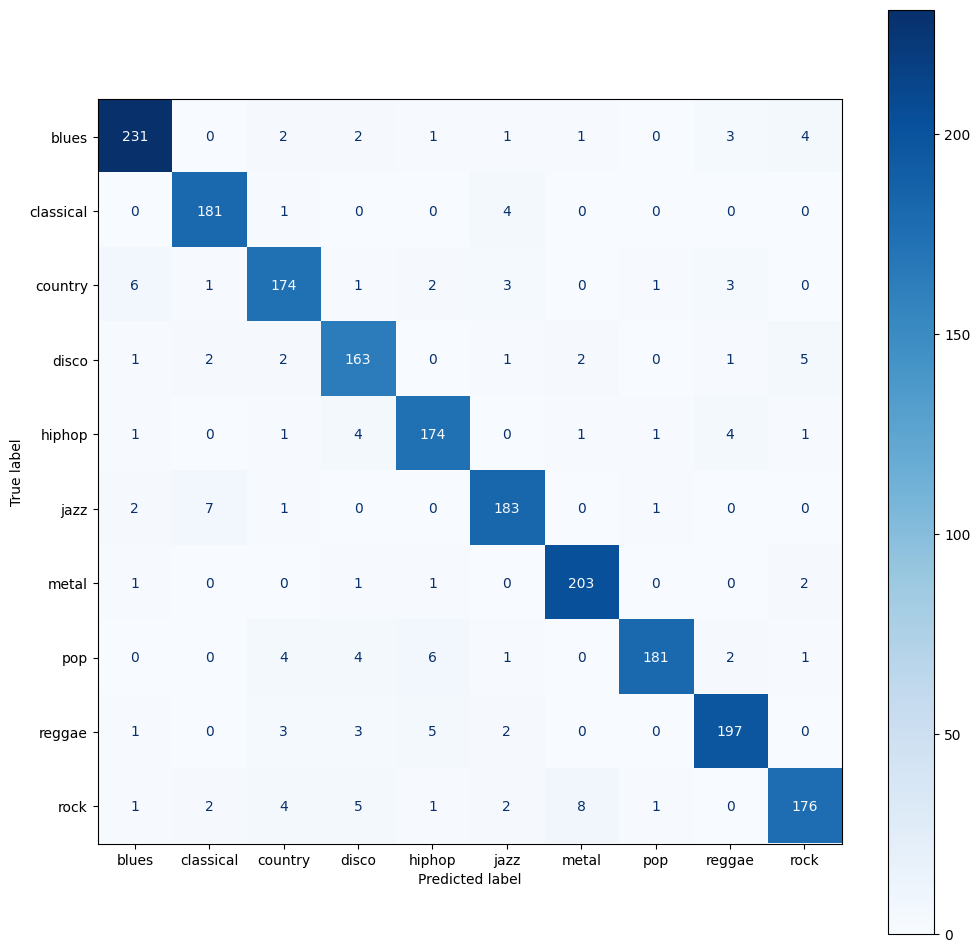

In [30]:
svm_bp = SVC(C=21, gamma='auto', kernel='rbf')
svm_bp.fit(X_train_sr, y_train)
svm_bp_pred = svm_bp.predict(X_test_sr)
print(f'Metrics for SVM:\n{get_metrics(y_test, svm_bp_pred)}')

The results for SVM with the best parameters are pretty good and it is one of the best models so far.

---

## LDA

Metrics for LDA:
Accuracy: 0.6626626626626627
Precision: 0.6675357589502297
Recall: 0.6626626626626627
F1: 0.6612238610223243
Confusion Matrix:


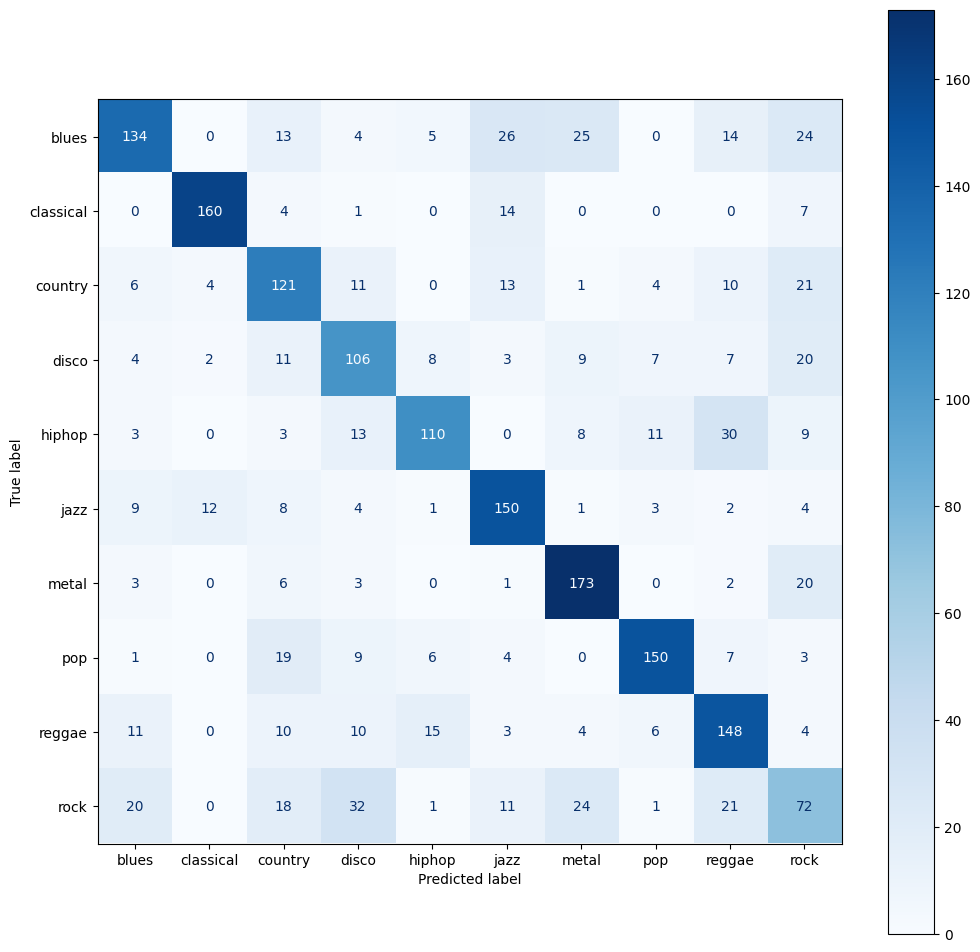

In [31]:
lda = LDA()
lda.fit(X_train_sr, y_train)
lda_pred = lda.predict(X_test_sr)
print(f'Metrics for LDA:\n{get_metrics(y_test, lda_pred)}')

The results for LDA are not very impressive; however, we can further improve it using GridSearchCV to get the best parameters according to F1 score for LDA using cross validation techniques.

In [32]:
gs_lda = GridSearchCV(estimator=lda, param_grid={
    'solver': ['lsqr', 'eigen', 'svd'],
    'shrinkage': ['auto', 0.0, 0.2, 0.5, 0.8, 1.0],
    'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}, scoring='f1_macro', cv=5, n_jobs=-1)
gs_lda.fit(X_train_sr, y_train)
gs_lda.best_params_

{'n_components': 1, 'shrinkage': 0.0, 'solver': 'lsqr'}

Metrics for LDA:
Accuracy: 0.6626626626626627
Precision: 0.6675357589502297
Recall: 0.6626626626626627
F1: 0.6612238610223243
Confusion Matrix:


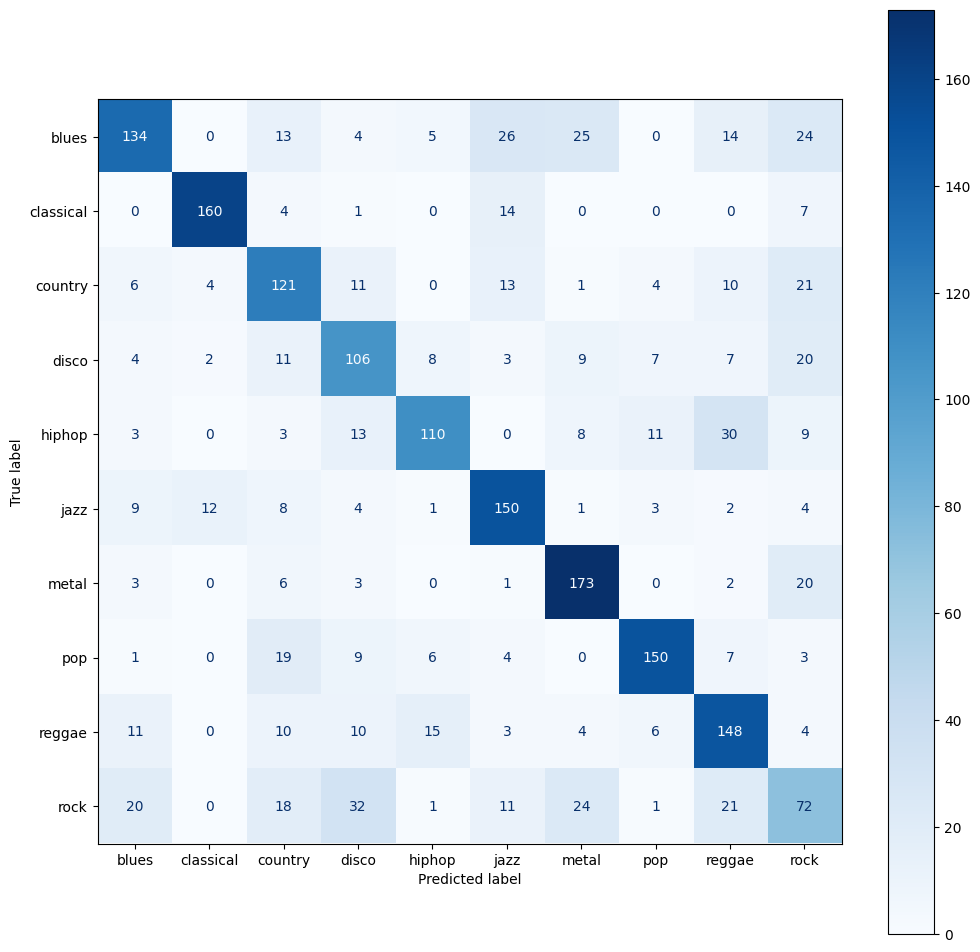

In [33]:
lda_bp = LDA(shrinkage=0.0, solver='lsqr', n_components=1)
lda_bp.fit(X_train_sr, y_train)
lda_bp_pred = lda.predict(X_test_sr)
print(f'Metrics for LDA:\n{get_metrics(y_test, lda_bp_pred)}')

The results for LDA with the best parameters are not very different from the default parameters and it was worse then our previous model. This can be explained by the fact that LDA assumes that the data is normally distributed and that the covariance matrices are equal across all classes, which is not the case in our data.

In [ ]:
covariances = {}
for genre in df['label'].unique():
    genre_data = X_train_sr[y_train == genre]
    covariances[genre] = np.cov(genre_data, rowvar=False)

genres = list(covariances.keys())
print(f"Shape of covariance matrix for {genres[0]}: {covariances[genres[0]].shape}")
print(f"Shape of covariance matrix for {genres[1]}: {covariances[genres[1]].shape}")

print(f"First 5 elements of covariance matrix for {genres[0]}: {covariances[genres[0]][0][:5]}")
print(f"First 5 elements of covariance matrix for {genres[1]}: {covariances[genres[1]][0][:5]}")

Shape of covariance matrix for blues: (46, 46)
Shape of covariance matrix for classical: (46, 46)
First 5 elements of covariance matrix for blues: [ 0.54215057 -0.2775189   0.20554914  0.00867269  0.17679426]
First 5 elements of covariance matrix for classical: [ 0.4807494  -0.05032723  0.06236942  0.00635941  0.01821988]


---

## QDA

Metrics for QDA:
Accuracy: 0.7692692692692693
Precision: 0.7768020806274537
Recall: 0.7692692692692693
F1: 0.7682362290412111
Confusion Matrix:


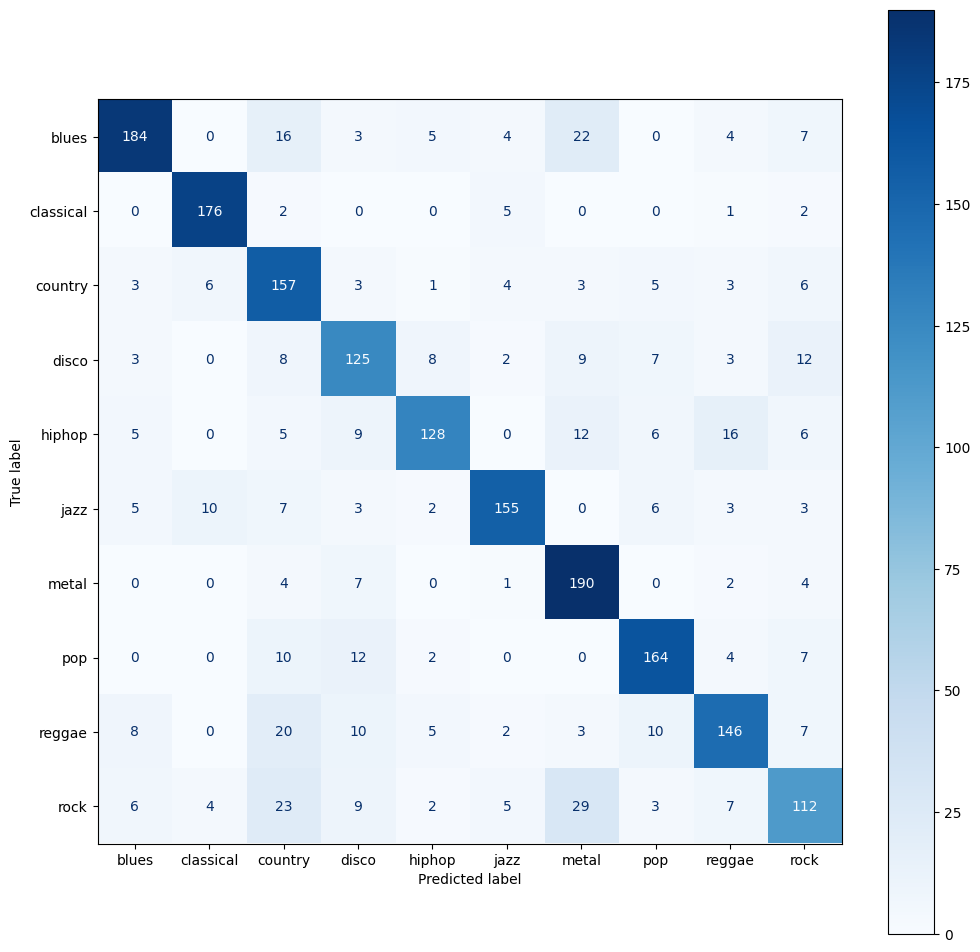

In [37]:
qda = QDA()
qda.fit(X_train_sr, y_train)
qda_pred = qda.predict(X_test_sr)
print(f'Metrics for QDA:\n{get_metrics(y_test, qda_pred)}')

The results for QDA are not very impressive; however, we can further improve it using GridSearchCV to get the best parameters according to F1 score for QDA using cross validation techniques.

In [38]:
gs_qda = GridSearchCV(estimator=qda, param_grid={
    'reg_param': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
}, scoring='f1_macro', cv=5, n_jobs=-1)
gs_qda.fit(X_train_sr, y_train)
gs_qda.best_params_

{'reg_param': 0.0}

Metrics for QDA:
Accuracy: 0.7692692692692693
Precision: 0.7768020806274537
Recall: 0.7692692692692693
F1: 0.7682362290412111
Confusion Matrix:


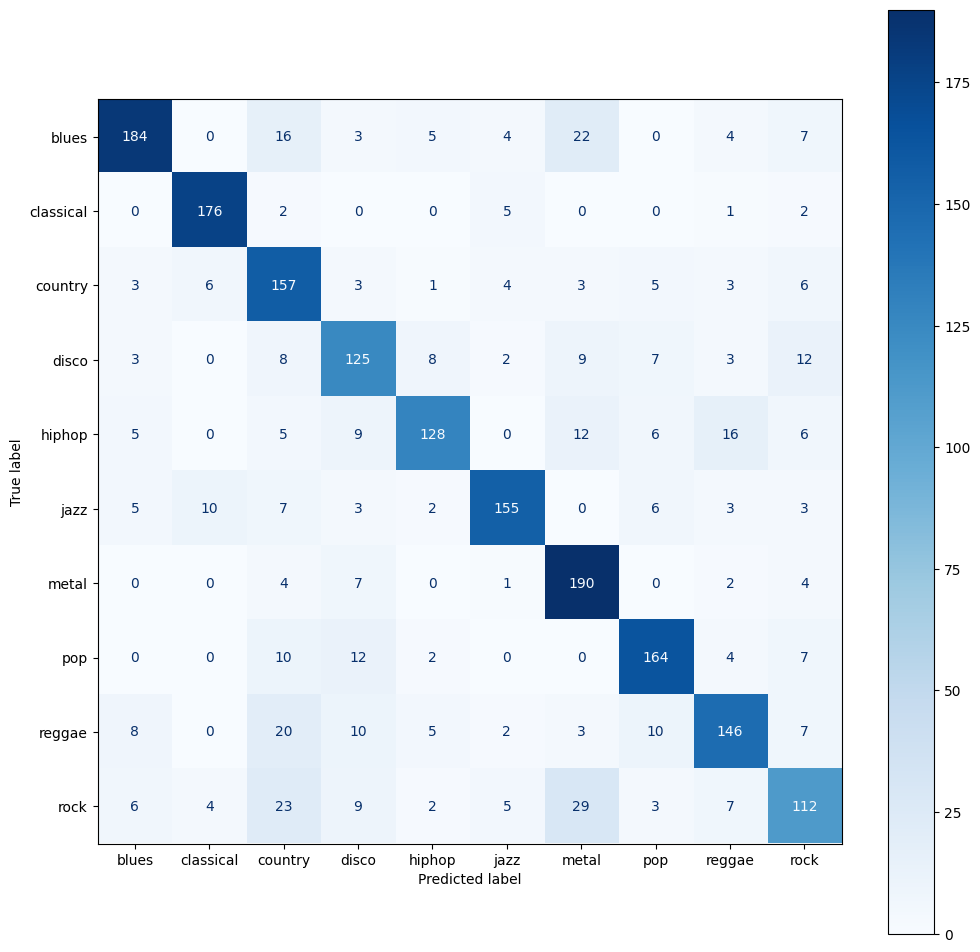

In [40]:
qda_bp = QDA(reg_param=0.0)
qda_bp.fit(X_train_sr, y_train)
qda_bp_pred = qda_bp.predict(X_test_sr)
print(f'Metrics for QDA:\n{get_metrics(y_test, qda_bp_pred)}')

The results for QDA with the best parameters are not very different from the default parameters and it was worse then our previous model. This can be explained by the fact that QDA assumes that the data is normally distributed, which is not the case in our data.

---

## Hist Gradient Boosting

Metrics for HistGradientBoostingClassifier:
Accuracy: 0.9134134134134134
Precision: 0.9144040124688003
Recall: 0.9134134134134134
F1: 0.9135451630206829
Confusion Matrix:


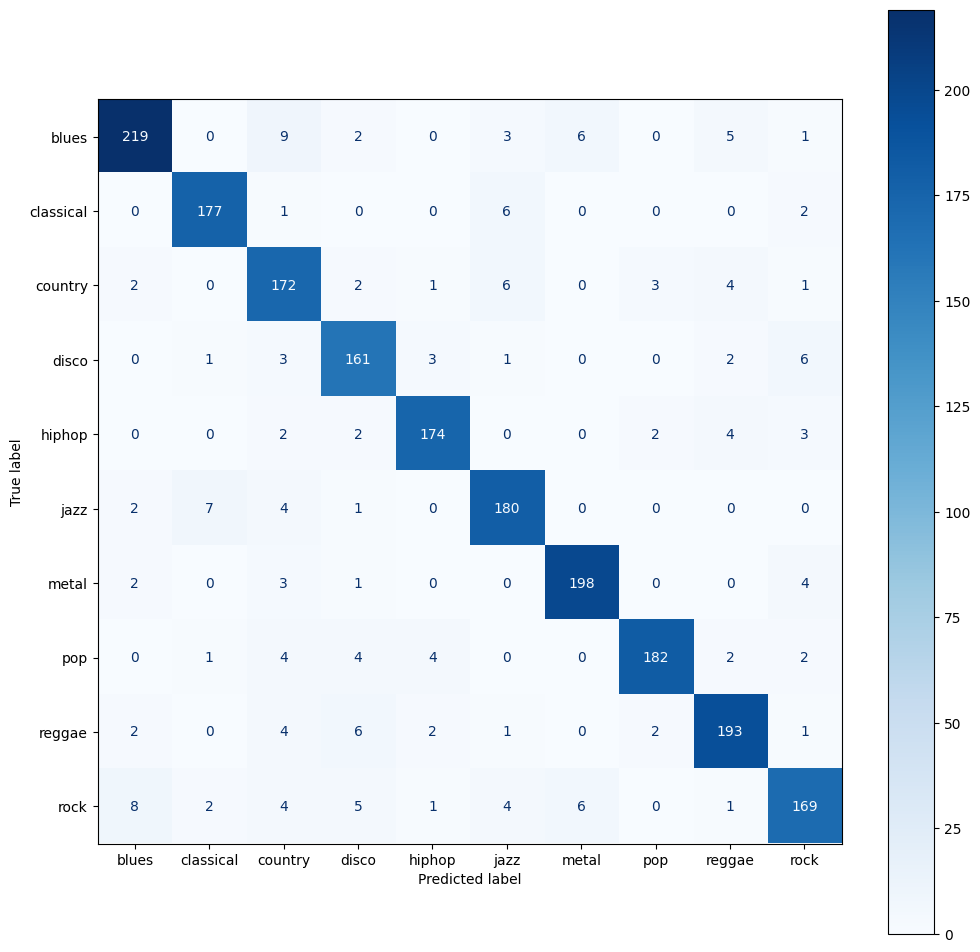

In [44]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(X_train_sr, y_train)
hgbc_pred = hgbc.predict(X_test_sr)
print(f'Metrics for HistGradientBoostingClassifier:\n{get_metrics(y_test, hgbc_pred)}')

The results for HistGradientBoostingClassifier are pretty good, but we can further improve it using GridSearchCV to get the best parameters according to F1 score for HistGradientBoostingClassifier using cross validation techniques.

In [45]:
gs_hgbc = GridSearchCV(
    hgbc,
    param_grid={
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [20, 50],
    'l2_regularization': [0.0, 0.1, 1.0]
},
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)
gs_hgbc.fit(X_train_sr, y_train)
gs_hgbc.best_params_

{'l2_regularization': 0.0,
 'learning_rate': 0.2,
 'max_depth': None,
 'max_iter': 200,
 'min_samples_leaf': 50}

Metrics for HistGradientBoostingClassifier:
Accuracy: 0.9214214214214215
Precision: 0.9219771187109921
Recall: 0.9214214214214215
F1: 0.9214510817925667
Confusion Matrix:


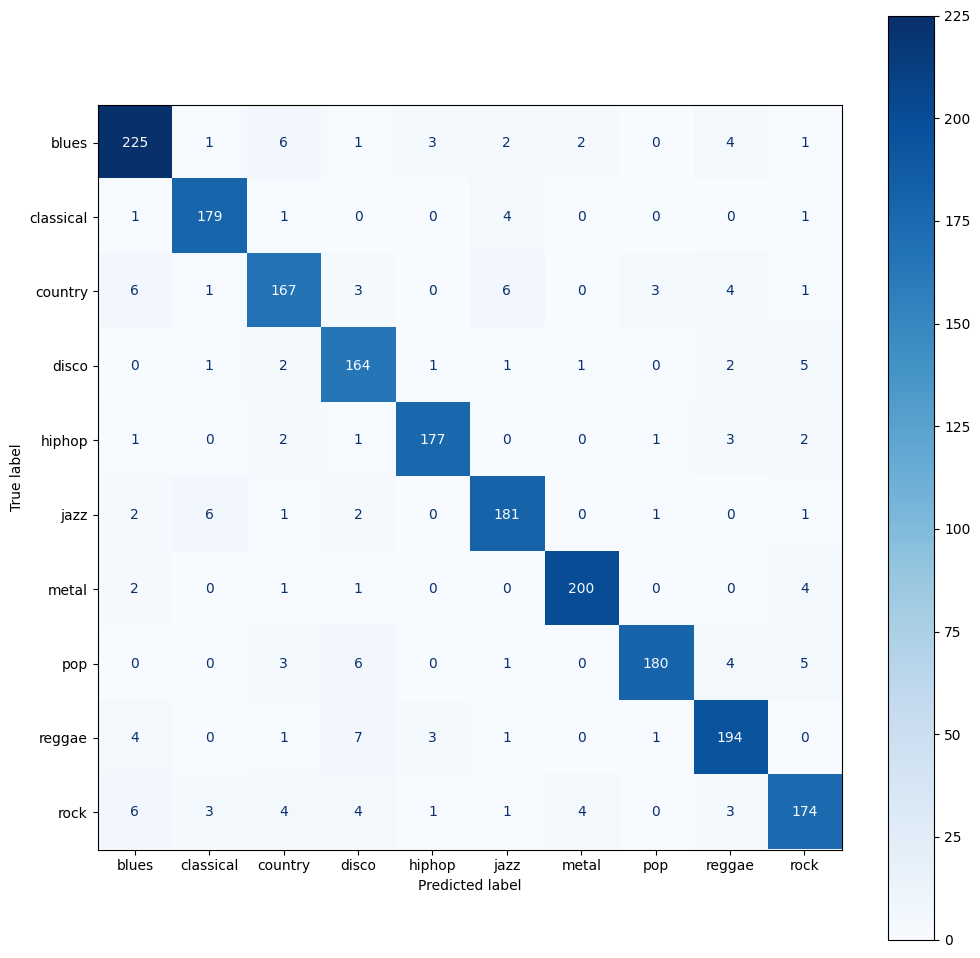

In [46]:
hgbc_bp = HistGradientBoostingClassifier(l2_regularization=0.0,
                                         learning_rate=0.2,
                                         max_depth=None,
                                         max_iter=200,
                                         min_samples_leaf=50)
hgbc_bp.fit(X_train_sr, y_train)
hgbc_bp_pred = hgbc_bp.predict(X_test_sr)
print(f'Metrics for HistGradientBoostingClassifier:\n{get_metrics(y_test, hgbc_bp_pred)}')

The results for HistGradientBoostingClassifier with the best parameters are pretty good and it is one of the best models so far. The reason for this is that HistGradientBoostingClassifier is a very powerful model that can handle non-linear relationships between the data and the labels. It is also less prone to overfitting than other models, such as Random Forest.

---

## Voting Classifier

Metrics for VotingClassifier:
Accuracy: 0.9354354354354354
Precision: 0.936292391857206
Recall: 0.9354354354354354
F1: 0.9354520321275757
Confusion Matrix:


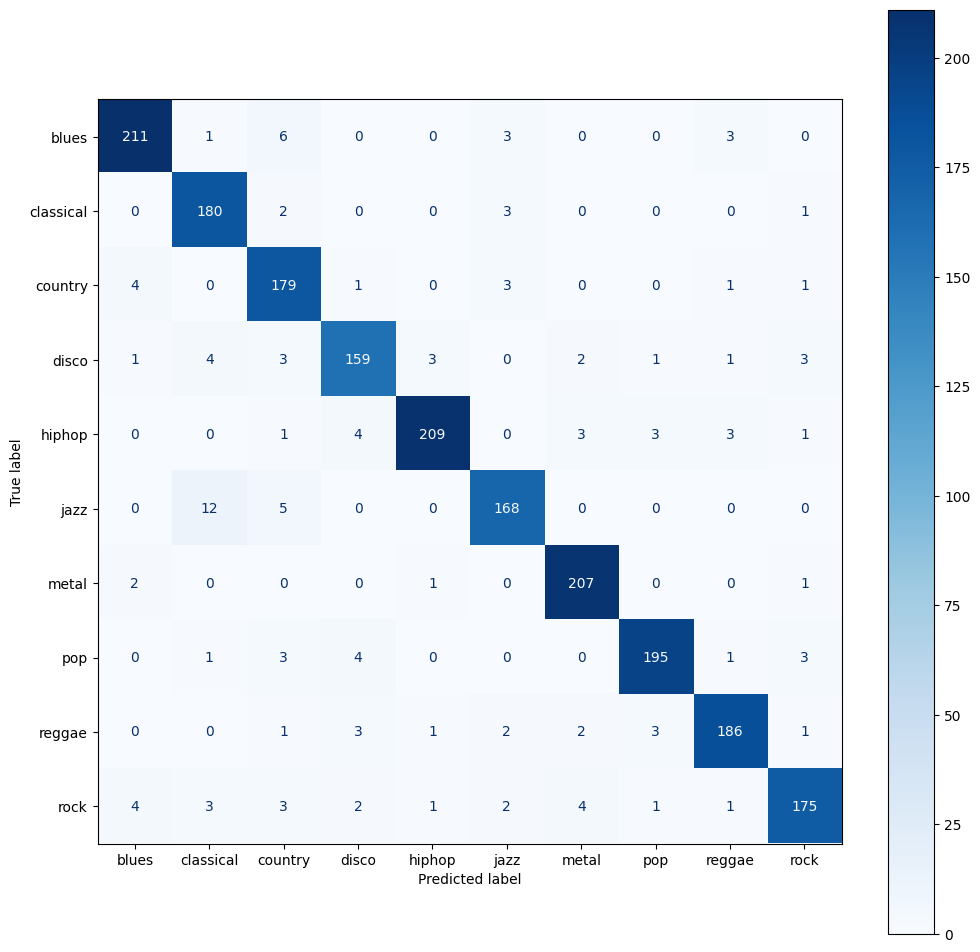

In [ ]:
svm_bp_prob = SVC(C=21, gamma='auto', kernel='rbf', probability=True)
vc = VotingClassifier(estimators=[
    ('rf', rf_reduced),
    ('knn', knn_bp),
    ('gnb', gnb),
    ('lr', lr_bp),
    ('lda', lda_bp),
    ('qda', qda_bp),
    ('hgbc', hgbc_bp),
    ('svm', svm_bp_prob)
], weights=[2,2,1,1,1,1,2,2], voting='soft')
vc.fit(X_train_sr, y_train)
vc_pred = vc.predict(X_test_sr)
print(f'Metrics for VotingClassifier:\n{get_metrics(y_test, vc_pred)}')

The Voting Classifier combines multiple machine learning models to make predictions. It leverages the strengths of different algorithms to improve overall performance. In our case, we have experimented with different weights to see which combination of models will give a better result.

---


## Conclusion

In this project, we explored various machine learning models for music genre recognition using the GTZAN dataset. We started with basic models like Random Forest and k-Nearest Neighbors, and then moved on to more complex models like Support Vector Machines and HistGradientBoostingClassifier. We also experimented with ensemble methods like VotingClassifier.

Here's a summary of the best performance achieved by each model:

*   **Random Forest:** Achieved good initial results, which were further improved using GridSearchCV for hyperparameter tuning and feature selection.
*   **k-NN:** Performed well, with cross-validation enhancing the results.
*   **Gaussian Naive Bayes:** Showed less impressive results, likely due to the violation of its feature independence assumption.
*   **Logistic Regression:** Delivered good results, but hyperparameter tuning did not significantly improve performance.
*   **SVM:** Provided one of the best performances, especially after hyperparameter tuning with cross-validation to select the optimal kernel.
*   **LDA:** Did not perform as well, possibly due to the data not meeting LDA's distributional assumptions.
*   **QDA:** Similar to LDA, QDA's performance was limited by the data's characteristics.
*   **HistGradientBoostingClassifier:** Stood out as one of the best models, effectively handling non-linear relationships and showing less tendency to overfit.
*   **Voting Classifier:** Combined the strengths of multiple models, achieving a competitive performance.

Overall, the **HistGradientBoostingClassifier** and **SVM** models provided the best performance in music genre recognition, demonstrating their ability to capture complex patterns in the data.
```

## Ranking of the models based on their F1 scores on the test set, from best to worst:
|Rank|Model|F1 Score|
|---|---|---|
|1|**VotingClassifier**|0.935|
|2|**SVM (Tuned)**|0.932|
|3|**HistGradientBoostingClassifier (Tuned)**|0.921|
|4|**k-NN (Tuned)**|0.891|
|5|**Random Forest (Reduced Features)**|0.865|
|6|**QDA (Tuned)**|0.768|
|7|**Logistic Regression**|0.714|
|8|**LDA (Tuned)**|0.661|
|9|**Gaussian Naive Bayes**|0.481|

### **Error Analysis on the Best Model (Voting Classifier)**

To better understand the performance of our best model—the **Voting Classifier**—we examined the confusion matrix to identify patterns of misclassification.

Overall, the model performs strongly across most genres; however, certain genres show noticeable confusion, particularly among acoustically or stylistically similar categories.

* A recurring issue is the **misclassification of jazz as classical**, likely due to overlapping instrumental and acoustic features between these two genres.
* Other frequent confusions occur between genres such as:

  * **Metal and rock**
  * **Pop and disco**
  * **Rock and blues**

These misclassifications are understandable given the subtle similarities in rhythm, instrumentation, or timbre within these genre pairs, even there can be labeling issue in the dataset or the authors may classify their works to other generes.

To address these issues and further improve the model’s performance, we suggest:

* **Expanding the training dataset** to provide more representative examples and reduce class overlap.
* **Leveraging Neural Network architectures** since we have access to raw `.wav` files and their spectrogram representations. 

By incorporating deep learning and more diverse training samples, the model could better capture nuanced genre distinctions and reduce confusion between similar classes.